In [1]:
%load_ext autoreload
%autoreload 2
%xmode Plain

from precompiled import *

Exception reporting mode: Plain


In [2]:
from data import *

train_dataset, val_dataset, test_dataset, original_test_dataset

Running tokenizer on dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/510 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/90 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 2400
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 510
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 90
 }),
 Dataset({
     features: ['text'],
     num_rows: 90
 }))

In [3]:
fine_tuned = GPT2LMHeadModel.from_pretrained(model_name)

In [4]:
# Fine-Tuning

data_collator = DataCollatorWithPadding(tokenizer)

DIR_FINETUNE = create_work_dir("tmp/pred/fine-tuning/")
last_checkpoint = get_last_checkpoint(DIR_FINETUNE)
print(f"last checkpoint: {last_checkpoint}")
training_args = TrainingArguments(
    output_dir=DIR_FINETUNE,
    overwrite_output_dir=True,
    num_train_epochs=10,  # if more, will overfit.
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    eval_strategy="steps",
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=2,
    logging_dir=DIR_FINETUNE,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,
    log_level="warning",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=4,
    # eval_accumulation_steps=4,
    weight_decay=0.01,
    warmup_steps=500,
    prediction_loss_only=True,

    # max_steps=2,  # TODO
)

trainer = Trainer(
    model=fine_tuned,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train(resume_from_checkpoint=last_checkpoint)

del trainer
release()

print_rouge_score_2(fine_tuned, test_dataset)
print_perplexity(fine_tuned, tokenizer, original_test_dataset)

# save
fine_tuned.save_pretrained(DIR_FINETUNE)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


last checkpoint: tmp/pred/fine-tuning/checkpoint-370


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Step,Training Loss,Validation Loss
100,13.787400,2.082999
200,8.688500,2.051144
300,8.381500,2.043357


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'test_loss': 2.0115301609039307, 'test_model_preparation_time': 0.0017, 'test_rouge1': 0.5963481233414064, 'test_rouge2': 0.1947077085916068, 'test_rougeL': 0.39089284795055723, 'test_rougeLsum': 0.5781347713389784, 'test_runtime': 43.1867, 'test_samples_per_second': 2.084, 'test_steps_per_second': 0.533}


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Perplexity (mean): 18.25


In [5]:
# Distillation

from distillation import *

DIR_DISTIL = create_work_dir("tmp/pred/distillation/")
last_checkpoint = get_last_checkpoint(DIR_DISTIL)

teacher = fine_tuned
# teacher has no need to update itself
teacher.requires_grad_(False)
teacher.eval()

student = create_student(teacher)
print_size(student)

distiller_model = Distiller(teacher=teacher, student=student)

training_args = TrainingArguments(
    output_dir=DIR_DISTIL,
    num_train_epochs=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    # eval_accumulation_steps=1,
    warmup_steps=500,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    learning_rate=5e-5,
    logging_dir=DIR_DISTIL,
    logging_steps=200,
    logging_first_step=True,
    log_level="warning",
    save_safetensors=False,
    fp16=torch.cuda.is_available(),

    # max_steps=2,  # TODO
)

trainer = Trainer(
    model=distiller_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train(resume_from_checkpoint=last_checkpoint)

# release
del trainer
release()

print_rouge_score_2(student, test_dataset)
print_perplexity(student, tokenizer, original_test_dataset)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model size: 0.31 GB


Step,Training Loss,Validation Loss
200,25.572600,2.739316
400,17.833000,2.309971
600,15.458100,2.133620
800,14.059800,1.994099
1000,13.306500,1.906371
1200,12.742800,1.851009
1400,12.322800,1.823377
1600,12.021800,1.786264
1800,11.671700,1.765524
2000,11.504800,1.736456


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'test_loss': 2.4396932125091553, 'test_model_preparation_time': 0.0009, 'test_rouge1': 0.5461419310261344, 'test_rouge2': 0.15002971656494976, 'test_rougeL': 0.3282063439953625, 'test_rougeLsum': 0.527172857574441, 'test_runtime': 34.9503, 'test_samples_per_second': 2.575, 'test_steps_per_second': 0.658}


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

Perplexity (mean): 31.98


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


last checkpoint: None


Output()

Step,Training Loss,Validation Loss
100,10.069300,2.288450
200,10.128900,2.326391
300,10.238200,2.364873
400,10.322400,2.425534
500,10.498800,2.468225
600,10.514600,2.537802
700,10.430500,2.590955
800,10.390200,2.639328
900,10.558100,2.644592
1000,10.738800,2.694686


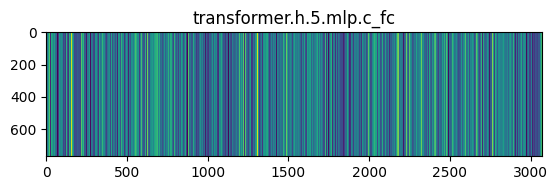

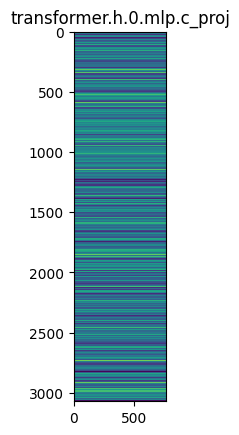

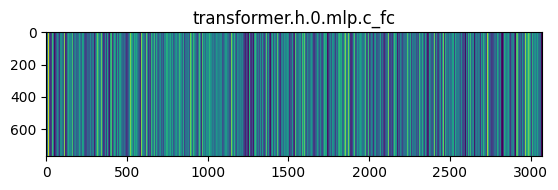

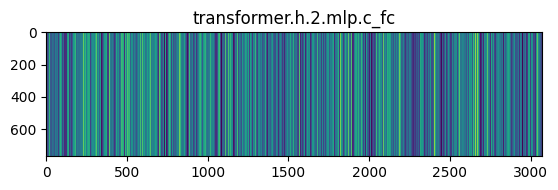

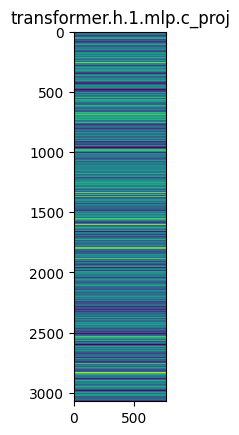

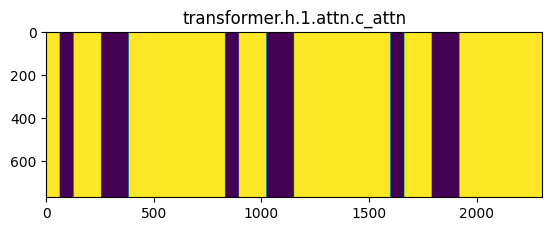

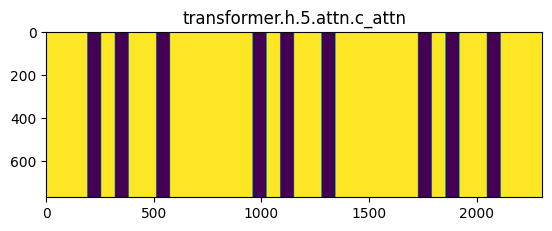

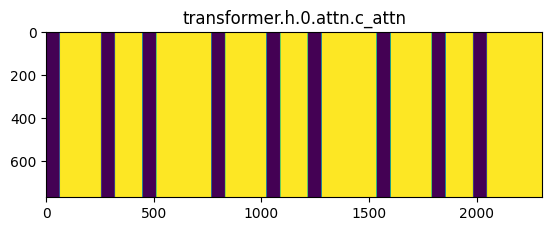

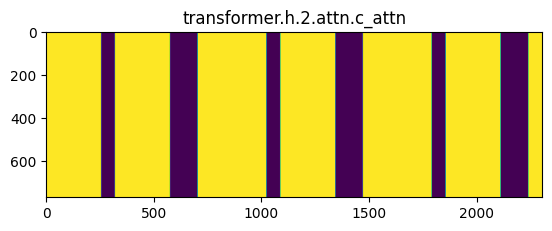

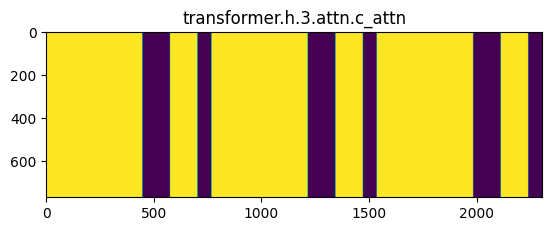

transformer.h.0.attn.c_attn: row density: 1.0; col density: 1.0
transformer.h.0.attn.c_proj: row density: 1.0; col density: 1.0
transformer.h.0.mlp.c_fc: row density: 1.0; col density: 0.4
transformer.h.0.mlp.c_proj: row density: 0.4; col density: 1.0
transformer.h.1.attn.c_attn: row density: 1.0; col density: 1.0
transformer.h.1.attn.c_proj: row density: 1.0; col density: 1.0
transformer.h.1.mlp.c_fc: row density: 1.0; col density: 0.4
transformer.h.1.mlp.c_proj: row density: 0.4; col density: 1.0
transformer.h.2.attn.c_attn: row density: 1.0; col density: 1.0
transformer.h.2.attn.c_proj: row density: 1.0; col density: 1.0
transformer.h.2.mlp.c_fc: row density: 1.0; col density: 0.4
transformer.h.2.mlp.c_proj: row density: 0.4; col density: 1.0
transformer.h.3.attn.c_attn: row density: 1.0; col density: 1.0
transformer.h.3.attn.c_proj: row density: 1.0; col density: 1.0
transformer.h.3.mlp.c_fc: row density: 1.0; col density: 0.4
transformer.h.3.mlp.c_proj: row density: 0.4; col densi

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model size: 0.23 GB


{'test_loss': 2.935351610183716, 'test_model_preparation_time': 0.001, 'test_rouge1': 0.48713304665100426, 'test_rouge2': 0.10964006523577871, 'test_rougeL': 0.2721584813488309, 'test_rougeLsum': 0.4692395605691126, 'test_runtime': 34.6926, 'test_samples_per_second': 2.594, 'test_steps_per_second': 0.663}


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

Perplexity (mean): 68.27


In [6]:
# pruning
from pruning import *

model = student
to_prune = convert_model(model)

# scheduler.progress = 1.0
# scheduler.attn_threshold = scheduler.attn_final_threshold
# scheduler.ffn_threshold = scheduler.ffn_final_threshold

DIR_PRUNE = create_work_dir("tmp/pred/pruning/")
last_checkpoint = get_last_checkpoint(DIR_PRUNE)
print(f"last checkpoint: {last_checkpoint}")
training_args = TrainingArguments(
    output_dir=DIR_PRUNE,
    overwrite_output_dir=True,
    num_train_epochs=p_train_config.epochs,
    per_device_train_batch_size=p_train_config.batch_size,
    eval_strategy="steps",
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=2,
    logging_dir=DIR_PRUNE,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,   # predict_with_generate=True works only in evaluation phase
    log_level="warning",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=p_train_config.gradient_accumulation_steps,
    weight_decay=0.01,
    warmup_steps=500,
    save_safetensors=False,  # we share masked scores between K,Q,V and between fc1,fc2.
    prediction_loss_only=True,

    # max_steps=2,  # TODO
)

trainer = Trainer(
    model=to_prune,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[SchedulerUpdateCallback()],
)

trainer.train(resume_from_checkpoint=last_checkpoint)

# release
del trainer
release()

print_pruning_density(to_prune)
FFN_freeze(to_prune)
print_linear_density_all(to_prune)
FFN_prune_zeros(to_prune)
ATTN_prune_zeros(to_prune)
print_size(to_prune)

print_rouge_score_2(to_prune, test_dataset)
print_perplexity(to_prune, tokenizer, original_test_dataset)

# print(to_prune)

In [7]:
# PTQ, QAT
from quantization import *

model = to_prune
ptq = get_ptq_model(model)

DIR_QUANTIZE = create_work_dir("tmp/pred/quantization/")
last_checkpoint = get_last_checkpoint(DIR_QUANTIZE)
print(f"last checkpoint: {last_checkpoint}")
training_args = TrainingArguments(
    output_dir=DIR_QUANTIZE,
    overwrite_output_dir=True,
    num_train_epochs=q_train_config.epochs,
    per_device_train_batch_size=q_train_config.batch_size,
    eval_strategy="steps",
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=1,
    logging_dir=DIR_QUANTIZE,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,
    log_level="warning",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=q_train_config.gradient_accumulation_steps,
    weight_decay=0.01,
    warmup_steps=500,
    prediction_loss_only=True,

    # max_steps=2,  # TODO
)

trainer = Trainer(
    model=ptq,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train(resume_from_checkpoint=last_checkpoint)

# release
del trainer
release()

print_rouge_score_2(ptq, test_dataset)
print_perplexity(ptq, tokenizer, original_test_dataset)

freeze(ptq)
print_size(ptq)

FINAL_FILE = DIR_QUANTIZE + "final.pth"
torch.save(ptq, FINAL_FILE)  # TODO: save state dict only and save the scale dict in json.

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


last checkpoint: None


Step,Training Loss,Validation Loss
100,9.993100,2.736084
200,9.839400,2.731814
300,9.828200,2.734849
400,9.750700,2.735830
500,9.590000,2.738337
600,9.560300,2.743417
700,9.457600,2.745441


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'test_loss': 2.9025278091430664, 'test_model_preparation_time': 0.0009, 'test_rouge1': 0.5020782403928756, 'test_rouge2': 0.11459371128039508, 'test_rougeL': 0.2783668831461792, 'test_rougeLsum': 0.48307838086304156, 'test_runtime': 33.9275, 'test_samples_per_second': 2.653, 'test_steps_per_second': 0.678}


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Perplexity (mean): 65.66
Model size: 0.17 GB


In [8]:
model = torch.load(FINAL_FILE)
thaw(model)

def print_prediction(model, text, name: str):
    input_ids = tokenizer.encode(text, return_tensors="pt", truncation=True, padding=True, max_length=model.config.n_positions)
    input_ids = input_ids[0, :100].unsqueeze(0)
    with torch.no_grad():
        output = model.generate(
            input_ids.to(device),
            min_new_tokens=50,
            max_new_tokens=200,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
        )
    gen_prediction = tokenizer.decode(output[0], skip_special_tokens=True)

    score1 = rouge_score.compute(predictions=[gen_prediction], references=[text])
    scores1 = {k: round(v, 4) for k, v in score1.items()}
    score2 = Perplexity.compute([text], model, tokenizer, device=device,
                                batch_size=1, max_length=model.config.n_positions)
    print(f">>> {name}\t: Generated Text: [{gen_prediction}]")
    print(f"{scores1} {score2}")

fine_tuned.eval()
model.eval()

random_samples = random.sample(range(len(original_test_dataset)), 5)
for idx in random_samples:
    text = original_test_dataset[idx]['text'][:-100]
    print(f"=================== {idx} =====================")
    print_prediction(fine_tuned, text, "origin")
    print("===========================")
    print_prediction(model, text, "opt   ")
    print()



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=================== 81 =====================


100%|██████████| 1/1 [00:00<00:00, 19.56it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> origin	: Generated Text: [(CNN) When it comes to shocking developments in the winding probe into President Donald Trump's campaign, the 2016 election, the Russians, hacking, allegations of collusion, and who-knows-what-else, the revelation on Thursday that special counsel Robert Mueller had issued grand jury subpoenas somehow managed to feel like an anticlimax.

Mueller's particular concern in this case appears to be Donald Trump Jr.'s meeting with a Russian lawyer, among others, at Trump Tower in June 2016. The meeting was reportedly arranged by the Trump campaign and the Russian government, according to a report by The New York Times. Mueller's office has not yet released the meeting, but it is believed that the lawyer was asked to provide Trump with information about the campaign's contacts with the Kremlin. Trump has denied any wrongdoing. He has also denied that he had any knowledge of the meetings. In addition, Mueller has subpoenaed the emails of a number of Trump associates

100%|██████████| 1/1 [00:00<00:00, 20.25it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> opt   	: Generated Text: [(CNN) When it comes to shocking developments in the winding probe into President Donald Trump's campaign, the 2016 election, the Russians, hacking, allegations of collusion, and who-knows-what-else, the revelation on Thursday that special counsel Robert Mueller had issued grand jury subpoenas somehow managed to feel like an anticlimax.

Mueller's particular concern in this case appears to be Donald Trump Jr.'s meeting with a Russian lawyer, among others, at Trump Tower in June. (AP)
The meeting was held in Trump, but the Russian attorney, who was in office for the Trump campaign. Mueller's meeting, was not disclosed. The meeting ended up being held on Friday night, when the meeting took place. It was unclear whether Mueller was asked to discuss the matter. But the Kremlin's attorney said that the meetings were not discussed. "The Russians were in meetings with the president and the media," the lawyer said.]
{'rouge1': 0.2569, 'rouge2': 0.1788, 'rougeL': 0.

100%|██████████| 1/1 [00:00<00:00, 19.51it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> origin	: Generated Text: [The ‘non-religious’ are the largest group in the State after Catholics, according to the last census. They range from active atheists lobbying for a secular Ireland to guilty non-believers who still observe religious rituals, writes RÓISÍN INGLE

A FEW WEEKS ago Brian Whiteside of the Humanist Association of Ireland addressed a gathering that included Taoiseach Enda Kenny, Minister for Justice Alan Shatter as well as various religious leaders.
‘Non-Christians are not the only ones who are concerned about the future of our country.” he said. “We are also concerned that the Irish Catholic Church is not being represented in government. We are worried that it is being used as a political tool to further the interests of religious groups. The Irish Church has been a powerful force in our society for many years. It is a very important part of society. I think that is why we are so concerned. There are a lot of people who think the Church should be represented. B

100%|██████████| 1/1 [00:00<00:00, 20.38it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> opt   	: Generated Text: [The ‘non-religious’ are the largest group in the State after Catholics, according to the last census. They range from active atheists lobbying for a secular Ireland to guilty non-believers who still observe religious rituals, writes RÓISÍN INGLE

A FEW WEEKS ago Brian Whiteside of the Humanist Association of Ireland addressed a gathering that included Taoiseach Enda Kenny, Minister for Justice Alan Shatter as well as various religious leaders.
“The group‘s membership is a nonreligious organization,” he said. “It‒s a group that„s not just religious, but also a religious organization that is not religiously affiliated with the Catholic Church.—
The groups have been active in recent years, including the National Register, which has been linked to a number of religious groups. The group has also been affiliated to Catholic organizations.]
{'rouge1': 0.1241, 'rouge2': 0.0924, 'rougeL': 0.1125, 'rougeLsum': 0.121} {'perplexities': [68.39715576171875], 'mean_perp

100%|██████████| 1/1 [00:00<00:00, 38.30it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> origin	: Generated Text: [Ohio Gov. John Kasich is reportedly set to drop out of the presidential race, according to NBC News ' Andrea Mitchell.

Multiple oulets confirmed that the governor will officially suspend his campaign later on Wednesday. Kasich's campaign scrapped a press conference planned for early Wednesday morning and instead announced the governor would make a statement in Columbus at 5 p.m. ET.

The Kasich campaign didn't immediately respond to a request for comment from Business Insider.

Presumptive Republican presidential nominee Donald Trump has been a strong supporter of Kasich, who has said he would not run for president. But Kasich has also been critical of Trump, saying he is "not a great leader."
“I don’t think he”s a leader,‘ Kasich said in a recent interview with The New York Times. “He�ll be a very tough guy. I don't think that‒s going to happen.‗
]
{'rouge1': 0.5571, 'rouge2': 0.4594, 'rougeL': 0.5181, 'rougeLsum': 0.5515} {'perplexities': [10.9613952636

100%|██████████| 1/1 [00:00<00:00, 43.59it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> opt   	: Generated Text: [Ohio Gov. John Kasich is reportedly set to drop out of the presidential race, according to NBC News ' Andrea Mitchell.

Multiple oulets confirmed that the governor will officially suspend his campaign later on Wednesday. Kasich's campaign scrapped a press conference planned for early Wednesday morning and instead announced the governor would make a statement in Columbus at 5 p.m. ET.

The Kasich campaign didn't immediately respond to a request for comment from Business Insider.

Presumptive Republican presidential nominee John McCain has been scheduled to appear in the upcoming presidential debate, but the timing of his announcement is unclear. The timing is likely to be a surprise. But the news outlet, who has previously reported that he will not announce his resignation. "The timing will be an indication that John will continue to hold the campaign until the end of this week," the source told NBC.com.]
{'rouge1': 0.5627, 'rouge2': 0.4594, 'rougeL': 0.529

100%|██████████| 1/1 [00:00<00:00, 19.56it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> origin	: Generated Text: [Richard Cordray has been rumored to be considering a run for governor of Ohio, but he gave no indication Wednesday of what his plans are. | Pete Marovich/Getty Images Cordray to resign from CFPB, clouding future of watchdog agency

Richard Cordray, the embattled director of the Consumer Financial Protection Bureau, will resign his post at the end of the month, giving President Donald Trump the chance to reshape an agency that has drawn relentless attacks from businesses over its aggressive enforcement.
Story Continued Below



Cordray's departure comes as the agency is facing a barrage of criticism from business groups and consumer advocates over the bureau's handling of consumer complaints. The bureau has faced criticism for failing to adequately investigate and prosecute consumer fraud, and for not adequately investigating and prosecuting predatory lending practices. It has also faced scrutiny for its handling and handling by the Obama administration of 

100%|██████████| 1/1 [00:00<00:00, 20.39it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> opt   	: Generated Text: [Richard Cordray has been rumored to be considering a run for governor of Ohio, but he gave no indication Wednesday of what his plans are. | Pete Marovich/Getty Images Cordray to resign from CFPB, clouding future of watchdog agency

Richard Cordray, the embattled director of the Consumer Financial Protection Bureau, will resign his post at the end of the month, giving President Donald Trump the chance to reshape an agency that has drawn relentless attacks from businesses over its aggressive enforcement.
“I’m not going to see the president of a company that is going on to take a stand at all,” Cordry said. “It‘s a big deal, and it‒s going through the very end.„I don‍t want to say anything about it. I—m just going forward to the presidency. It s not a good deal. That―s what I want. And I don't want it to do. But I think it is a deal that‗s the biggest deal I have ever seen. So I can‛t say it, I am not looking for it because I feel it would be a huge deal for 

100%|██████████| 1/1 [00:00<00:00, 35.10it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>>> origin	: Generated Text: [Get the biggest daily stories by email Subscribe Thank you for subscribing We have more newsletters Show me See our privacy notice Could not subscribe, try again later Invalid Email

A man was found dead in his home after having sex with a scarecrow that he had dressed up in a wig, lipstick and strap-on sex toy.

The rotting remains of Jose Alberto were discovered in his home after neighbours reported a foul smell coming from the building.

Police forced their way into the home in San Francisco on Wednesday night to find the body of the man, who was wearing a black wig and lipstick. He was pronounced dead at the scene. Police said the victim had been sexually assaulted. The man had a tattoo on his right hand. His body was later found in the kitchen.]
{'rouge1': 0.624, 'rouge2': 0.5098, 'rougeL': 0.5738, 'rougeLsum': 0.6072} {'perplexities': [10.678180694580078], 'mean_perplexity': 10.678180694580078}


100%|██████████| 1/1 [00:00<00:00, 39.27it/s]

>>> opt   	: Generated Text: [Get the biggest daily stories by email Subscribe Thank you for subscribing We have more newsletters Show me See our privacy notice Could not subscribe, try again later Invalid Email

A man was found dead in his home after having sex with a scarecrow that he had dressed up in a wig, lipstick and strap-on sex toy.

The rotting remains of Jose Alberto were discovered in his home after neighbours reported a foul smell coming from the building.

Police forced their way into the home in San Francisco to find a dead. They found the man in the house, and they were found in their bedroom. The man's bedroom was discovered, in an upstairs bedroom, with the blood and teeth. He was taken to the hospital and found a blood clot in him. A man who was in her room was arrested was ordered to take the following call.]
{'rouge1': 0.5984, 'rouge2': 0.4878, 'rougeL': 0.5499, 'rougeLsum': 0.5876} {'perplexities': [27.698532104492188], 'mean_perplexity': 27.698532104492188}


In [9]:
print_rouge_score_2(fine_tuned, test_dataset)
print_rouge_score_2(model, test_dataset)

print_perplexity(fine_tuned, tokenizer, original_test_dataset)
print_perplexity(model, tokenizer, original_test_dataset)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'test_loss': 2.0115301609039307, 'test_model_preparation_time': 0.0017, 'test_rouge1': 0.5963481233414064, 'test_rouge2': 0.1947077085916068, 'test_rougeL': 0.39089284795055723, 'test_rougeLsum': 0.5781347713389784, 'test_runtime': 34.8169, 'test_samples_per_second': 2.585, 'test_steps_per_second': 0.661}


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'test_loss': 2.9016966819763184, 'test_model_preparation_time': 0.001, 'test_rouge1': 0.5021639238080926, 'test_rouge2': 0.11516827233275936, 'test_rougeL': 0.2789747734234966, 'test_rougeLsum': 0.48315212881547076, 'test_runtime': 34.0337, 'test_samples_per_second': 2.644, 'test_steps_per_second': 0.676}


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Perplexity (mean): 18.25


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

Perplexity (mean): 65.52
